<a href="https://colab.research.google.com/github/Nithyasri-Babu/customer-segmentation/blob/main/Finalrfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Improved customer segmentation + RFM pipeline.

Features:
- Preserve existing customer_id or create stable new ones
- Deterministic name generation when missing
- Smart matching (phone, exact keys, fuzzy name fallback)
- Total fallback: unit_price * quantity if total missing
- Frequency = unique purchase days
- Snapshot = max(date) + 1 day
- Robust RFM scoring + safe qcut fallback
- Automatic best-k selection via silhouette with safe fallbacks
- Centroid / statistic-based cluster labeling
- Exports final dataset + rfm summary
"""

import re
import unicodedata
from datetime import datetime
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from difflib import SequenceMatcher  # standard fuzzy-ish fallback

# ---------------- CONFIG ----------------
INPUT_CSV = "/content/modified_supermarket_data.csv"
OUTPUT_CSV = "clean_customer_dataset_final_improved.csv"
OUTPUT_RFM_SUMMARY = "rfm_summary_by_cluster_improved.csv"
RANDOM_STATE = 42
NEW_ID_PREFIX = f"CUS-{datetime.now().year}"
MAX_K = 6   # test up to min(MAX_K, n_customers)
NAME_SIMILARITY_THRESHOLD = 0.86  # 0..1, higher => stricter fuzzy match
MIN_CLUSTER_SIZE_FOR_SIL = 2
# ----------------------------------------

np.random.seed(RANDOM_STATE)

# ---------------- helpers ----------------
def normalize_text(s):
    if pd.isna(s):
        return ""
    t = str(s).strip().lower()
    t = unicodedata.normalize("NFKD", t)
    t = re.sub(r"[^\w\s]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

def clean_phone(raw):
    if pd.isna(raw):
        return ""
    s = str(raw)
    digits = re.sub(r"\D+", "", s)
    digits = digits.lstrip("0")
    return digits

def parse_monetary(x):
    """Parse numeric monetary; return np.nan if invalid"""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s == "":
        return np.nan
    s = s.replace(",", "")
    s = re.sub(r"[^\d\.\-]", "", s)
    try:
        return float(s)
    except:
        return np.nan

def safe_int(x, default=0):
    try:
        if pd.isna(x):
            return default
        return int(float(x))
    except:
        return default

# deterministic name generator
FIRST_NAMES = ["alex","sam","maya","raj","priya","li","omar","fatima","arjun","kavya",
               "sara","noah","liam","emma","oliver","ava","mohammad","rahul","maria","anna"]
LAST_NAMES  = ["k","singh","patel","reddy","rao","smith","chen","khan","garcia","das",
               "lopez","nguyen","silva","rodriguez","thomas","pereira","martin","yadav","more","perez"]

def generate_name(seed: str, idx: int) -> str:
    h = abs(hash(str(seed) + "_" + str(idx)))
    first = FIRST_NAMES[h % len(FIRST_NAMES)]
    last = LAST_NAMES[(h // len(FIRST_NAMES)) % len(LAST_NAMES)]
    return f"{first.title()} {last.title()}"

def generate_customer_id(num):
    return f"{NEW_ID_PREFIX}-{num:06d}"

def name_similarity(a: str, b: str) -> float:
    if not a or not b:
        return 0.0
    return SequenceMatcher(None, a, b).ratio()

def safe_qcut(series, q, labels):
    try:
        return pd.qcut(series, q=q, labels=labels, duplicates='drop').astype(float)
    except Exception:
        ranks = series.rank(method='average', pct=True)
        bins = np.linspace(0,1,q+1)
        return pd.cut(ranks, bins=bins, labels=labels).astype(float)

# centroid-based cluster label assignment
def assign_cluster_labels(rfm_df):
    # rfm_df: contains cluster, Recency_days, Frequency, Monetary
    summary = rfm_df.groupby('Cluster').agg(
        recency_mean=('Recency_days','mean'),
        frequency_mean=('Frequency','mean'),
        monetary_mean=('Monetary','mean')
    ).reset_index()
    # Rank clusters by monetary & frequency & recency
    # Create score with weights (monetary 0.5, frequency 0.3, recency -0.2 (lower recency better))
    med_mon = summary['monetary_mean'].median()
    med_freq = summary['frequency_mean'].median()
    med_rec = summary['recency_mean'].median()
    labels = {}
    # We'll rank clusters by monetary_mean primarily
    for _, r in summary.iterrows():
        c = r['Cluster']
        money = r['monetary_mean']
        freq = r['frequency_mean']
        rec = r['recency_mean']
        # simple heuristic
        if (money >= med_mon) and (freq >= med_freq) and (rec <= med_rec):
            labels[c] = 'Champions'
        elif (money >= med_mon) and (freq >= med_freq):
            labels[c] = 'Loyal High-Value'
        elif (rec <= med_rec) and (money < med_mon):
            labels[c] = 'Potential'
        elif (rec > med_rec) and (money >= med_mon):
            labels[c] = 'At Risk (Value Previous)'
        else:
            labels[c] = 'Low Value / Lost'
    return labels, summary

# ---------------- pipeline ----------------
def run_pipeline(input_csv=INPUT_CSV):
    # 1. load
    df = pd.read_csv(input_csv, dtype=str)
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    print(f"Loaded {len(df)} rows. Columns: {list(df.columns)}")

    # 2. basic cleaning
    df = df.drop_duplicates().copy()

    # required columns check
    if 'total' not in df.columns:
        raise ValueError("Input must contain 'total' column.")
    if 'date' not in df.columns:
        raise ValueError("Input must contain 'date' column.")
    if 'invoice_id' not in df.columns:
        df['invoice_id'] = df.index.to_series().apply(lambda i: f"SYN_INV_{i}")

    # normalize text fields
    for col in ['customer_type','gender','region','product_line','payment','customer_name']:
        if col in df.columns:
            df[col] = df[col].fillna('').astype(str).apply(normalize_text)
        else:
            df[col] = ''

    # clean phone
    if 'phone' in df.columns:
        df['phone'] = df['phone'].fillna('').astype(str).apply(clean_phone)
    else:
        df['phone'] = ''

    # parse monetary fields and fallback to unit_price * quantity if total invalid
    df['total_parsed'] = df['total'].apply(parse_monetary)
    # parse unit_price and quantity
    if 'unit_price' in df.columns:
        df['unit_price_parsed'] = df['unit_price'].apply(parse_monetary)
    else:
        df['unit_price_parsed'] = np.nan
    if 'quantity' in df.columns:
        df['quantity_parsed'] = df['quantity'].apply(safe_int)
    else:
        df['quantity_parsed'] = 0

    # fill missing totals using unit_price * quantity
    mask_missing_total = df['total_parsed'].isna()
    if mask_missing_total.any():
        computed = (df['unit_price_parsed'] * df['quantity_parsed']).where(~df['unit_price_parsed'].isna(), np.nan)
        df.loc[mask_missing_total, 'total_parsed'] = computed.loc[mask_missing_total]

    # final total column
    df['total'] = df['total_parsed']

    # drop rows where total still NaN
    n_bad = df['total'].isna().sum()
    if n_bad > 0:
        print(f"Dropping {n_bad} rows with invalid total after fallback.")
        df = df[~df['total'].isna()].copy()

    # 3. customer_name: generate deterministically where missing
    mask_missing_name = df['customer_name'].astype(str).str.strip() == ''
    if mask_missing_name.any():
        for idx in df[mask_missing_name].index:
            seed = df.at[idx, 'phone'] if df.at[idx, 'phone'] else df.at[idx, 'invoice_id']
            df.at[idx, 'customer_name'] = generate_name(seed, idx)
    # nice title column
    df['customer_name_title'] = df['customer_name'].str.title()

    # 4. preserve existing customer_id
    if 'customer_id' in df.columns:
        df['customer_id'] = df['customer_id'].where(df['customer_id'].notna(), None)
    else:
        df['customer_id'] = None

    # 5. build keys for matching
    df['key_phone'] = df['phone']
    df['key_name_gender_region'] = df['customer_name'].astype(str).str.lower() + '|' + df['gender'].fillna('') + '|' + df['region'].fillna('')
    df['key_name_region_ctype'] = df['customer_name'].astype(str).str.lower() + '|' + df['region'].fillna('') + '|' + df['customer_type'].fillna('')

    # build maps from existing customer_id entries
    phone_to_id = {}
    ngr_to_id = {}
    nrc_to_id = {}
    used_ids = set([str(x) for x in df['customer_id'].dropna().unique() if x])

    for idx, row in df[df['customer_id'].notna()].iterrows():
        cid = str(row['customer_id'])
        phone = row['key_phone']
        if phone:
            phone_to_id[phone] = cid
        ngr = row['key_name_gender_region']
        if ngr and ngr not in ngr_to_id:
            ngr_to_id[ngr] = cid
        nrc = row['key_name_region_ctype']
        if nrc and nrc not in nrc_to_id:
            nrc_to_id[nrc] = cid
        used_ids.add(cid)

    # determine starting counter for new ids
    import re
    pattern = re.compile(rf"{re.escape(NEW_ID_PREFIX)}-(\d+)$")
    max_existing = 0
    for uid in used_ids:
        m = pattern.match(uid)
        if m:
            try:
                n = int(m.group(1)); max_existing = max(max_existing, n)
            except:
                pass
    next_counter = max_existing + 1

    # stable ordering for deterministic assignment: by date (parsed) then invoice_id then phone
    df['_parsed_date_tmp'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
    df['_parsed_date_tmp'] = df['_parsed_date_tmp'].fillna(pd.Timestamp('1970-01-01'))
    order_idx = df.sort_values(['_parsed_date_tmp', 'invoice_id', 'phone']).index

    assigned_ids = []
    # apply assignment in deterministic order
    for idx in order_idx:
        row = df.loc[idx]
        if pd.notna(row['customer_id']) and str(row['customer_id']) != 'None':
            assigned_ids.append(str(row['customer_id'])); continue

        phone = row['key_phone']
        ngr = row['key_name_gender_region']
        nrc = row['key_name_region_ctype']

        # rule 1: phone exact
        if phone and phone in phone_to_id:
            cid = phone_to_id[phone]; assigned_ids.append(cid); continue

        # rule 2: name+gender+region exact
        if ngr and ngr in ngr_to_id:
            cid = ngr_to_id[ngr]
            if phone: phone_to_id[phone] = cid
            assigned_ids.append(cid); continue

        # rule 3: name+region+customer_type exact
        if nrc and nrc in nrc_to_id:
            cid = nrc_to_id[nrc]
            if phone: phone_to_id[phone] = cid
            assigned_ids.append(cid); continue

        # rule 4: fuzzy name fallback (search existing keys)
        matched = False
        if row['customer_name']:
            name_to_match = row['customer_name']
            # search in ngr_to_id keys (name part)
            for existing_key, existing_cid in ngr_to_id.items():
                existing_name = existing_key.split('|')[0]
                sim = name_similarity(name_to_match, existing_name)
                if sim >= NAME_SIMILARITY_THRESHOLD:
                    # also check region/gender consistency if present
                    # if both regions match or existing region blank, accept
                    # (we already used ngr keys that include region/gender, this helps)
                    cid = existing_cid
                    if phone: phone_to_id[phone] = cid
                    assigned_ids.append(cid)
                    matched = True
                    break
        if matched:
            continue

        # else generate new id
        while True:
            candidate = generate_customer_id(next_counter)
            next_counter += 1
            if candidate not in used_ids:
                used_ids.add(candidate)
                break
        cid = candidate
        # map keys
        if phone: phone_to_id[phone] = cid
        if ngr: ngr_to_id[ngr] = cid
        if nrc: nrc_to_id[nrc] = cid
        assigned_ids.append(cid)

    # write back and restore original order
    df = df.loc[order_idx].copy()
    df['customer_id'] = assigned_ids
    df = df.sort_index()
    df.drop(columns=[c for c in ['_parsed_date_tmp']], inplace=True, errors='ignore')

    # 6. Compute RFM
    # robust date parse with fallbacks already done in sorting, ensure again
    df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
    # fallback formats for any remaining NaT
    if df['date'].isna().any():
        common_formats = ["%d/%m/%Y", "%d-%m-%Y", "%m/%d/%Y", "%Y/%m/%d", "%Y-%m-%d"]
        for fmt in common_formats:
            mask = df['date'].isna()
            if not mask.any():
                break
            try:
                df.loc[mask, 'date'] = pd.to_datetime(df.loc[mask, 'date'].astype(str), format=fmt, errors='coerce')
            except:
                pass
    # fill remaining NaT with earliest valid date
    if df['date'].isna().all():
        raise ValueError("All dates failed to parse.")
    df['date'] = df['date'].fillna(df['date'].min())

    # Frequency: number of unique purchase days (more robust than invoice count)
    df['purchase_day'] = df['date'].dt.floor('D')

    snapshot = df['date'].max() + pd.Timedelta(days=1)

    rfm = df.groupby('customer_id').agg(
        Recency_days = ('date', lambda x: int((snapshot - x.max()).days)),
        Frequency = ('purchase_day', lambda x: x.nunique()),
        Monetary = ('total', 'sum')
    ).reset_index()

    rfm['Monetary'] = rfm['Monetary'].fillna(0.0)
    rfm['Recency_days'] = rfm['Recency_days'].clip(lower=0)

    # 7. RFM scoring (safe)
    r_labels = [5,4,3,2,1]  # recent -> high
    f_labels = [1,2,3,4,5]
    m_labels = [1,2,3,4,5]

    rfm['R_Score'] = safe_qcut(rfm['Recency_days'], 5, r_labels).astype(int)
    rfm['F_Score'] = safe_qcut(rfm['Frequency'], 5, f_labels).astype(int)
    rfm['M_Score'] = safe_qcut(rfm['Monetary'], 5, m_labels).astype(int)
    rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

    # map to segments
    rfm['RFM_Segment'] = pd.cut(
        rfm['RFM_Score'],
        bins=[0, 6, 9, 12, 15],
        labels=['Lost','At Risk','Potential','Champions']
    ).astype(str)

    # 8. Choose best K by silhouette
    features = ['Recency_days','Frequency','Monetary']
    X = rfm[features].astype(float).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    n_customers = len(rfm)

    if n_customers < 2:
        rfm['Cluster'] = 0
        print("Not enough customers for clustering; single cluster assigned.")
    else:
        best_k = None
        best_score = -1
        best_labels = None
        max_k = min(MAX_K, n_customers-1) if n_customers > 2 else 2
        # ensure at least test k=2
        k_candidates = list(range(2, max(2, max_k)+1))
        for k in k_candidates:
            try:
                km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
                labels = km.fit_predict(Xs)
                # check minimal cluster sizes
                unique, counts = np.unique(labels, return_counts=True)
                if counts.min() < MIN_CLUSTER_SIZE_FOR_SIL:
                    # skip silhouette if tiny clusters
                    continue
                if len(np.unique(labels)) > 1:
                    sil = silhouette_score(Xs, labels)
                    if sil > best_score:
                        best_score = sil
                        best_k = k
                        best_labels = labels
            except Exception:
                continue

        if best_k is None:
            # fallback to k=2 or min(3,n_customers)
            fallback_k = 2 if n_customers >= 2 else 1
            km = KMeans(n_clusters=fallback_k, random_state=RANDOM_STATE, n_init=10)
            best_labels = km.fit_predict(Xs)
            best_k = fallback_k
            best_score = None

        rfm['Cluster'] = best_labels
        if best_score is not None:
            print(f"Chosen k = {best_k} with silhouette = {best_score:.4f}")
        else:
            print(f"Chosen k = {best_k} (silhouette not available)")

    # 9. cluster summary and labeling
    labels_map, cluster_stats = assign_cluster_labels(rfm)
    rfm['Cluster_Label'] = rfm['Cluster'].map(labels_map)

    # 10. merge back to df
    df = df.merge(rfm[['customer_id','R_Score','F_Score','M_Score','RFM_Score','RFM_Segment','Cluster','Cluster_Label']], on='customer_id', how='left')

    # 11. final columns and save
    final_columns = [
        'invoice_id','branch','region','customer_type','gender',
        'product_line','unit_price','quantity','tax_5%','total',
        'date','time','payment','cogs','gross_margin_percentage',
        'gross_income','rating','phone','customer_name_title',
        'customer_id','RFM_Score','RFM_Segment','Cluster','Cluster_Label'
    ]
    for col in final_columns:
        if col not in df.columns:
            df[col] = np.nan
    final_df = df[final_columns].copy()
    final_df.rename(columns={'customer_name_title':'customer_name'}, inplace=True)

    final_df.to_csv(OUTPUT_CSV, index=False)
    cluster_stats.to_csv(OUTPUT_RFM_SUMMARY, index=False)

    print(f"Saved final dataset: {OUTPUT_CSV}")
    print(f"Saved cluster summary: {OUTPUT_RFM_SUMMARY}")
    return final_df, rfm, cluster_stats

# ---------------- main ----------------
if __name__ == "__main__":
    final_df, rfm_table, cluster_summary = run_pipeline(INPUT_CSV)


Loaded 1000 rows. Columns: ['invoice_id', 'branch', 'region', 'customer_type', 'gender', 'product_line', 'unit_price', 'quantity', 'tax_5%', 'total', 'date', 'time', 'payment', 'cogs', 'gross_margin_percentage', 'gross_income', 'rating', 'phone']


/tmp/ipython-input-3663148161.py:253: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['_parsed_date_tmp'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
/tmp/ipython-input-3663148161.py:326: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)


Chosen k = 2 with silhouette = 0.5364
Saved final dataset: clean_customer_dataset_final_improved.csv
Saved cluster summary: rfm_summary_by_cluster_improved.csv


**VISUALIZATION**

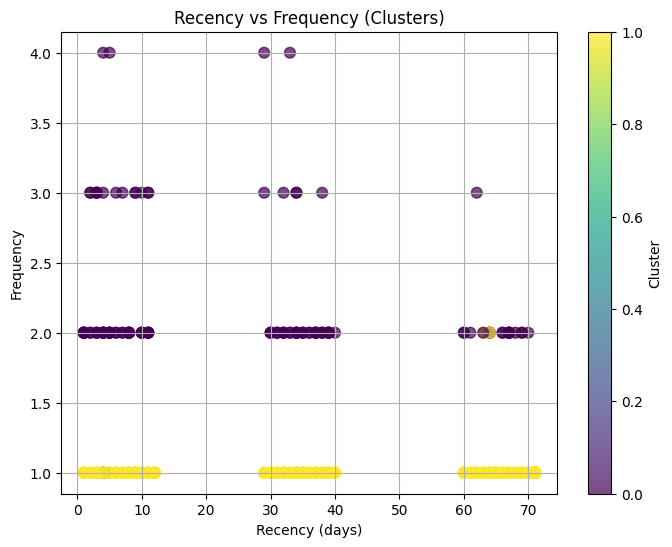

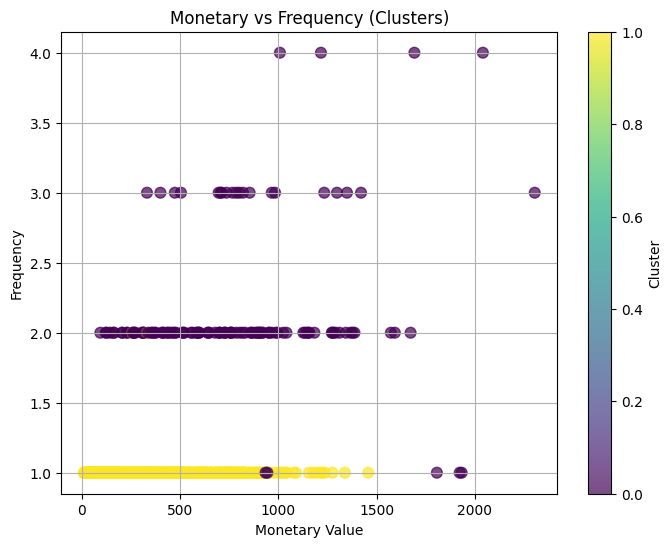

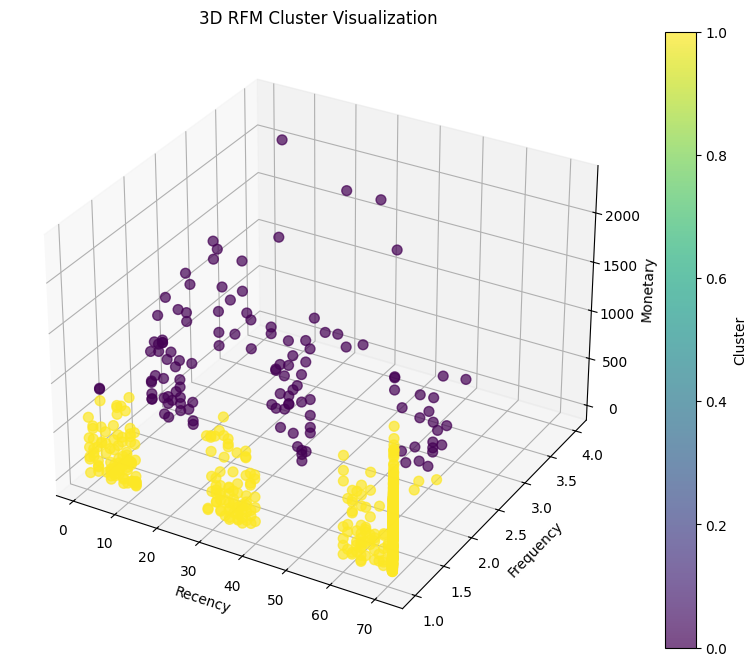

Silhouette Score: 0.5364


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ---------------------------------------------------------
# 1) SIMPLE 2D SCATTER: RECENCY vs FREQUENCY (colored by cluster)
# ---------------------------------------------------------
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    rfm_table["Recency_days"],
    rfm_table["Frequency"],
    c=rfm_table["Cluster"],
    s=60,
    alpha=0.7
)
plt.title("Recency vs Frequency (Clusters)")
plt.xlabel("Recency (days)")
plt.ylabel("Frequency")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 2) SIMPLE 2D SCATTER: MONETARY vs FREQUENCY
# ---------------------------------------------------------
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    rfm_table["Monetary"],
    rfm_table["Frequency"],
    c=rfm_table["Cluster"],
    s=60,
    alpha=0.7
)
plt.title("Monetary vs Frequency (Clusters)")
plt.xlabel("Monetary Value")
plt.ylabel("Frequency")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 3) 3D SCATTER: Recency - Frequency - Monetary
# ---------------------------------------------------------
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    rfm_table["Recency_days"],
    rfm_table["Frequency"],
    rfm_table["Monetary"],
    c=rfm_table["Cluster"],
    s=50,
    alpha=0.7
)

ax.set_title("3D RFM Cluster Visualization")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
fig.colorbar(p, ax=ax, label="Cluster")

plt.show()

# ---------------------------------------------------------
# 4) PRINT SILHOUETTE SCORE
# ---------------------------------------------------------
print("Silhouette Score:", round(silhouette_score(
    StandardScaler().fit_transform(
        rfm_table[['Recency_days','Frequency','Monetary']]
    ),
    rfm_table['Cluster']
),4))


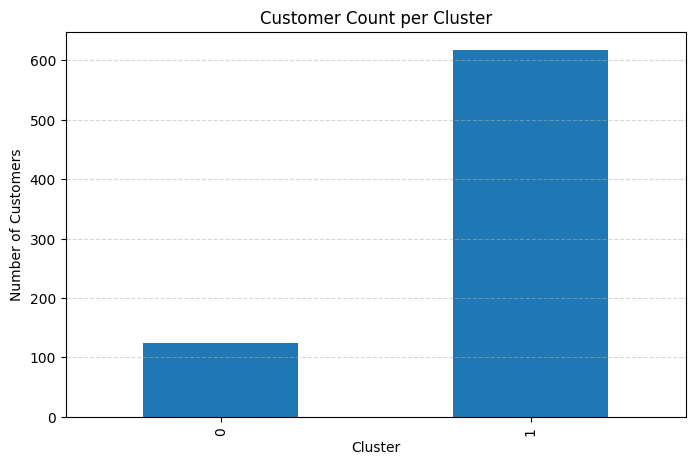

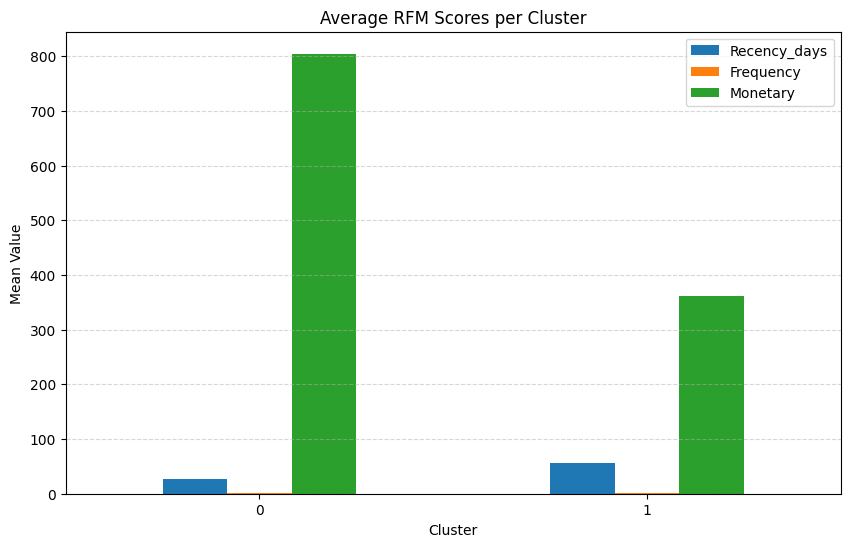

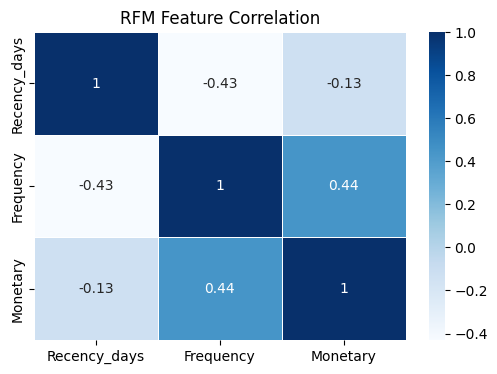

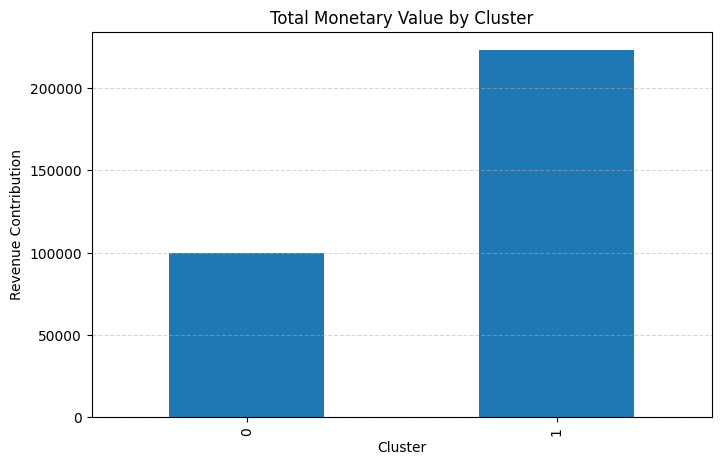

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# =================== 1) CLUSTER SIZE DISTRIBUTION ===================
plt.figure(figsize=(8,5))
rfm_table['Cluster'].value_counts().sort_index().plot(kind='bar')
plt.title("Customer Count per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# =================== 2) AVERAGE RFM PER CLUSTER ===================
cluster_means = rfm_table.groupby('Cluster')[['Recency_days','Frequency','Monetary']].mean()

cluster_means.plot(kind='bar', figsize=(10,6))
plt.title("Average RFM Scores per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Value")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.show()

# =================== 3) RFM CORRELATION HEATMAP ===================
plt.figure(figsize=(6,4))
sns.heatmap(
    rfm_table[['Recency_days','Frequency','Monetary']].corr(),
    annot=True,
    cmap='Blues',
    linewidths=0.5
)
plt.title("RFM Feature Correlation")
plt.show()

# =================== 4) MONETARY CONTRIBUTION BY CLUSTER ===================
cluster_revenue = rfm_table.groupby('Cluster')['Monetary'].sum()

plt.figure(figsize=(8,5))
cluster_revenue.plot(kind='bar')
plt.title("Total Monetary Value by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Revenue Contribution")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
